In [55]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog 
from numpy.linalg import solve
import urllib.request
import os
import matplotlib.pyplot as plt

In [172]:
power_g = np.array([15, 100, 32, 25, 70]) 
cost_g = np.array([75, 15, 0, 42, 10])

g = np.vstack((power_g, cost_g)).T
g = g[g[:,1].argsort()]
ng = power_g.shape[0]

power_d = np.array([35, 23, 12, 38, 43, 16, 57])
cost_d = np.array([65, 78, 10, 46, 63, 32, 50])
d = np.vstack((power_d, cost_d)).T
d = d[d[:,1].argsort()[::-1]]
nd = power_d.shape[0]

ids = [''] * (nd+ng)

for i in range(ng):
    ids[i] = 'G{}'.format(i+1)

for i in range(nd):
    ids[ng+i] = 'D{}'.format(i+1)
    
ids = np.array(ids)

In [159]:
np.array(['a', 'b'])

array(['a', 'b'], dtype='<U1')

In [102]:
xg = np.cumsum(g[:,0])
xg = np.insert(xg, 0, 0)
yg = g[:,1]
yg = np.insert(yg, 0, 0)

xd = np.cumsum(d[:,0])
xd = np.insert(xd, 0, 0)
yd = d[:,1]
yd = np.insert(yd, 0, yd[0])

# 4.1 and 4.2

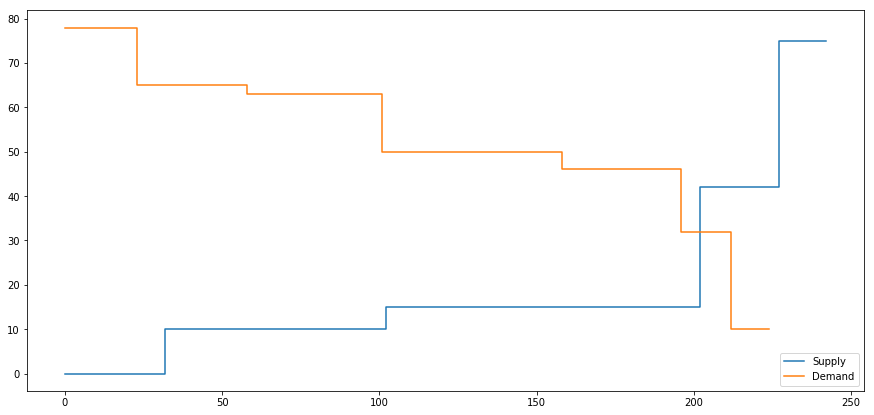

In [110]:
plt.figure(figsize=(15, 7))
plt.step(xg,yg, where = 'pre', label ='Supply')
plt.step(xd,yd, where = 'pre', label ='Demand')
plt.legend()

# 4.3

In [133]:
n_g = power_g.shape[0]
n_d = power_d.shape[0]

A_eq = np.array([np.concatenate((np.ones(n_g),-np.ones(n_d)))])

b_eq = 0

A = np.identity(A_eq.size)

b = np.array([np.concatenate((power_g, power_d))]).T

c = np.concatenate((cost_g, -cost_d))

res_std = linprog(c, A_eq=A_eq, b_eq = b_eq, A_ub=A, b_ub=b, bounds=(0, None))

gen_sch = res_std.x[:n_g]
dem_sch = res_std.x[n_g:]

print('Generation schedules:', gen_sch)
print('Demand schedules:', dem_sch)

print()        

print('Total energy scheduled: {} MWh'.format(gen_sch.sum()))

print()        

for i in range(gen_sch.shape[0]):
    if gen_sch[i] > 0:
        print('G{}: {} MWh'.format((i+1), gen_sch[i]))

print()        
        
for i in range(dem_sch.shape[0]):
    if dem_sch[i] > 0:
        print('D{}: {} MWh'.format((i+1),dem_sch[i]))


Generation schedules: [  0. 100.  32.   0.  70.]
Demand schedules: [35. 23.  0. 38. 43.  6. 57.]

Total energy scheduled: 202.0 MWh

G2: 100.0 MWh
G3: 32.0 MWh
G5: 70.0 MWh

D1: 35.0 MWh
D2: 23.0 MWh
D4: 38.0 MWh
D5: 43.0 MWh
D6: 6.0 MWh
D7: 57.0 MWh


In [234]:
a1 = np.ones(n_g)
a2 = -np.ones(n_d)
a3 = np.array([np.hstack((a1,a2))]).T
a4 = -np.identity((n_d + n_g))

A_tilde = np.concatenate((a4,a3),axis=1)

b_tilde = np.concatenate((cost_g, -cost_d))

c_tilde = np.append(-b, np.array([0]))

res_dual = linprog(-c_tilde, A_ub=A_tilde, b_ub=b_tilde)

eq_cost = res_dual.x[-1]
print('Cost: $ {}'.format(eq_cost))

Cost: $ 32.0


# Social Welfare

In [233]:
df = pd.DataFrame({'ID' : ids, 'Quantity [MWh]': np.concatenate((power_g, power_d)), 'Bid [$/MWh]': np.concatenate((cost_g, cost_d)), 'Cost [$/MWh]' : res_dual.x[-1], 'Scheduled [MWh]' : res_std.x})
df['Revenue'] = df['Cost [$/MWh]']*df['Scheduled [MWh]']

df_g = df[0:ng].values
df_d = df[ng:].values

SW = (df_d[:,2]*df_d[:,4]).sum() - (df_g[:,2]*df_g[:,4]).sum()

print('Social Walfare: $ {}'.format(SW))

Social Walfare: $ 9368.0
